In [179]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import seaborn as sns

In [106]:
df = pd.read_csv('reg_cars_selling.csv')
df

name  year  ...                     torque  seats
0           Maruti Swift Dzire VDI  2014  ...             190Nm@ 2000rpm    5.0
1     Skoda Rapid 1.5 TDI Ambition  2014  ...        250Nm@ 1500-2500rpm    5.0
2         Honda City 2017-2020 EXi  2006  ...      12.7@ 2,700(kgm@ rpm)    5.0
3        Hyundai i20 Sportz Diesel  2010  ...   22.4 kgm at 1750-2750rpm    5.0
4           Maruti Swift VXI BSIII  2007  ...      11.5@ 4,500(kgm@ rpm)    5.0
...                            ...   ...  ...                        ...    ...
8123             Hyundai i20 Magna  2013  ...           113.7Nm@ 4000rpm    5.0
8124         Hyundai Verna CRDi SX  2007  ...  24@ 1,900-2,750(kgm@ rpm)    5.0
8125        Maruti Swift Dzire ZDi  2009  ...             190Nm@ 2000rpm    5.0
8126               Tata Indigo CR4  2013  ...        140Nm@ 1800-3000rpm    5.0
8127               Tata Indigo CR4  2013  ...        140Nm@ 1800-3000rpm    5.0

[8128 rows x 13 columns]

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [108]:
df.isna().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

In [109]:
df.describe().round(2)

year  selling_price   km_driven    seats
count  8128.00        8128.00     8128.00  7907.00
mean   2013.80      638271.81    69819.51     5.42
std       4.04      806253.40    56550.55     0.96
min    1983.00       29999.00        1.00     2.00
25%    2011.00      254999.00    35000.00     5.00
50%    2015.00      450000.00    60000.00     5.00
75%    2017.00      675000.00    98000.00     5.00
max    2020.00    10000000.00  2360457.00    14.00

In [110]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: >

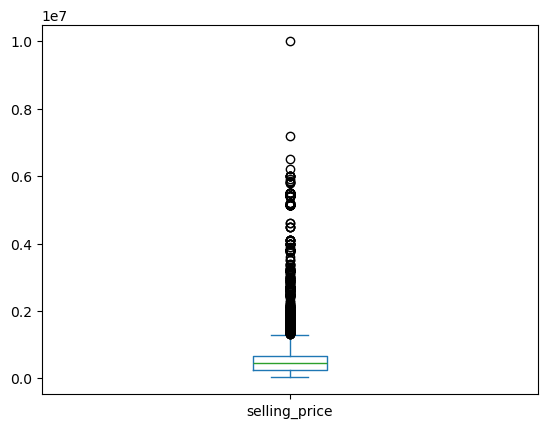

In [111]:
df['selling_price'].plot(kind='box')

In [112]:
# Function to clean and preprocess the dataset
def clean_and_preprocess(df):
    cleaned_df = df.copy()
    
    # Convert 'year' to car age
    current_year = 2025
    cleaned_df['car_age'] = current_year - cleaned_df['year']
    cleaned_df.drop(columns=['year'], inplace=True)
    
    # Extract numerical values from 'mileage', 'engine', and 'max_power'
    cleaned_df['mileage'] = cleaned_df['mileage'].str.extract(r'([\d\.]+)').astype(float)
    cleaned_df['engine'] = cleaned_df['engine'].str.extract(r'([\d\.]+)').astype(float)
    cleaned_df['max_power'] = cleaned_df['max_power'].str.extract(r'([\d\.]+)').astype(float)
    
    # Drop 'torque' as it is less useful directly
    cleaned_df.drop(columns=['torque'], inplace=True)
    
    # Handle missing values - filling or dropping based on feature relevance
    cleaned_df['mileage'].fillna(cleaned_df['mileage'].mean(), inplace=True)
    cleaned_df['engine'].fillna(cleaned_df['engine'].mean(), inplace=True)
    cleaned_df['max_power'].fillna(cleaned_df['max_power'].mean(), inplace=True)
    cleaned_df['seats'].fillna(cleaned_df['seats'].mode()[0], inplace=True)
    
    # Convert categorical variables to one-hot encoding
    cate_columns = ['fuel', 'seller_type', 'transmission', 'owner']
    cleaned_df = pd.get_dummies(cleaned_df, columns=cate_columns, drop_first=True)
    
    # Drop the 'name' column as it adds limited value without additional processing
    cleaned_df.drop(columns=['name'], inplace=True)
    
    return cleaned_df

# Apply preprocessing to the dataset
preprocessed_df = clean_and_preprocess(df)

# Display the first few rows of the cleaned dataset
preprocessed_df.head()

C:\Users\sif\AppData\Local\Temp\ipykernel_16988\1676263509.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_df['mileage'].fillna(cleaned_df['mileage'].mean(), inplace=True)
C:\Users\sif\AppData\Local\Temp\ipykernel_16988\1676263509.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

selling_price  km_driven  ...  owner_Test Drive Car  owner_Third Owner
0         450000     145500  ...                 False              False
1         370000     120000  ...                 False              False
2         158000     140000  ...                 False               True
3         225000     127000  ...                 False              False
4         130000     120000  ...                 False              False

[5 rows x 17 columns]

In [113]:
ProfileReport(preprocessed_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [114]:
preprocessed_df.isna().sum()

selling_price                   0
km_driven                       0
mileage                         0
engine                          0
max_power                       0
seats                           0
car_age                         0
fuel_Diesel                     0
fuel_LPG                        0
fuel_Petrol                     0
seller_type_Individual          0
seller_type_Trustmark Dealer    0
transmission_Manual             0
owner_Fourth & Above Owner      0
owner_Second Owner              0
owner_Test Drive Car            0
owner_Third Owner               0
dtype: int64

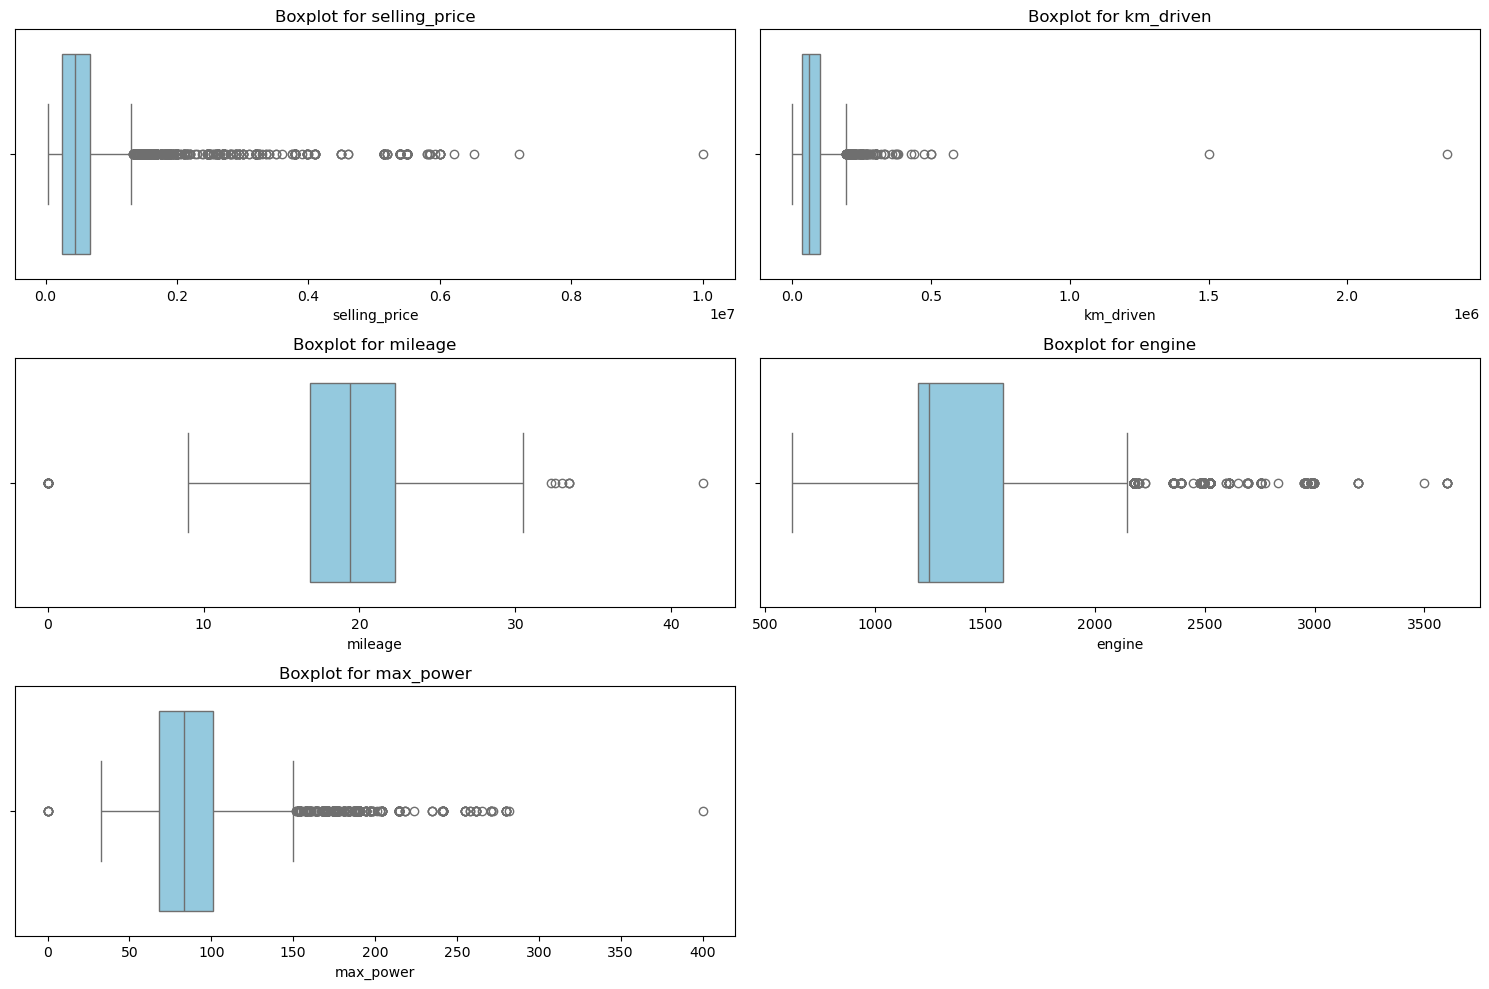

In [115]:
# Define numeric columns to analyze for outliers
num_columns = ['selling_price', 'km_driven', 'mileage', 'engine', 'max_power']

# Plot boxplots to visualize outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(num_columns, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=preprocessed_df, x=column, color='skyblue')
    plt.title(f'Boxplot for {column}')
plt.tight_layout()
plt.show()


In [116]:
# Splitting the data into features (X) and target (y)
X = preprocessed_df.drop(columns=['selling_price'])
y = preprocessed_df['selling_price']

In [117]:
X

km_driven  mileage  ...  owner_Test Drive Car  owner_Third Owner
0        145500    23.40  ...                 False              False
1        120000    21.14  ...                 False              False
2        140000    17.70  ...                 False               True
3        127000    23.00  ...                 False              False
4        120000    16.10  ...                 False              False
...         ...      ...  ...                   ...                ...
8123     110000    18.50  ...                 False              False
8124     119000    16.80  ...                 False              False
8125     120000    19.30  ...                 False              False
8126      25000    23.57  ...                 False              False
8127      25000    23.57  ...                 False              False

[8128 rows x 16 columns]

In [118]:
y

0       450000
1       370000
2       158000
3       225000
4       130000
         ...  
8123    320000
8124    135000
8125    382000
8126    290000
8127    290000
Name: selling_price, Length: 8128, dtype: int64

In [119]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [120]:
X_train

km_driven  mileage  ...  owner_Test Drive Car  owner_Third Owner
6518       2560    24.00  ...                 False              False
6144      80000    19.40  ...                 False              False
6381     150000    23.00  ...                 False              False
438      120000    23.40  ...                 False              False
5939      25000    23.95  ...                 False              False
...         ...      ...  ...                   ...                ...
5226     120000    12.05  ...                 False              False
5390      80000    23.40  ...                 False              False
860       35000    18.60  ...                 False              False
7603      27000    28.40  ...                 False              False
7270      70000    16.10  ...                 False              False

[6502 rows x 16 columns]

In [121]:
# Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [122]:
# Preprocessing for numerical and categorical columns
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [123]:
# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [124]:
# Define individual regressors
lr = LinearRegression()
svr = SVR()
rfr = RandomForestRegressor()
gbr = GradientBoostingRegressor()

In [125]:
# Define parameter grids for each model
param1 = {'regressor': [lr]}

param2 = {
    'regressor': [svr],
    'regressor__C': [10**-2, 10**-1, 10**0, 10**1, 10**2]
}

param3 = {
    'regressor': [rfr],
    'regressor__n_estimators': [50, 100, 200, 500],
    'regressor__max_depth': [5, 10, 20]
}

param4 = {
    'regressor': [gbr],
    'regressor__n_estimators': [50, 100, 200, 500],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__max_depth': [3, 5, 10]
}

In [126]:
# Combine all parameter grids
params = [param1, param2, param3, param4]

In [127]:
# Define pipeline
pipeline = Pipeline([('regressor', lr)])

In [128]:
# Perform Grid Search
gs = GridSearchCV(pipeline, params, cv=3, scoring='r2')

In [153]:
# Fit the model
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('regressor', LinearRegression())]),
             param_grid=[{'regressor': [LinearRegression()]},
                         {'regressor': [SVR()],
                          'regressor__C': [0.01, 0.1, 1, 10, 100]},
                         {'regressor': [RandomForestRegressor()],
                          'regressor__max_depth': [5, 10, 20],
                          'regressor__n_estimators': [50, 100, 200, 500]},
                         {'regressor': [GradientBoostingRegressor()],
                          'regressor__learning_rate': [0.01, 0.1, 0.2],
                          'regressor__max_depth': [3, 5, 10],
                          'regressor__n_estimators': [50, 100, 200, 500]}],
             scoring='r2')

In [155]:
gs.best_params_

{'regressor': GradientBoostingRegressor(),
 'regressor__learning_rate': 0.2,
 'regressor__max_depth': 3,
 'regressor__n_estimators': 500}

In [157]:
gs.best_score_

0.9597849237896753

In [159]:
joblib.dump(gs.best_estimator_,'car_model.pkl')

['car_model.pkl']

In [165]:
my_model = joblib.load('car_model.pkl')

In [171]:
sc = StandardScaler()

In [173]:
gs.best_estimator_

Pipeline(steps=[('regressor',
                 GradientBoostingRegressor(learning_rate=0.2,
                                           n_estimators=500))])

Mean Squared Error: 20508883040.90864
Mean Absolute Error: 71091.50044280321
R² Score: 0.9687118689983742


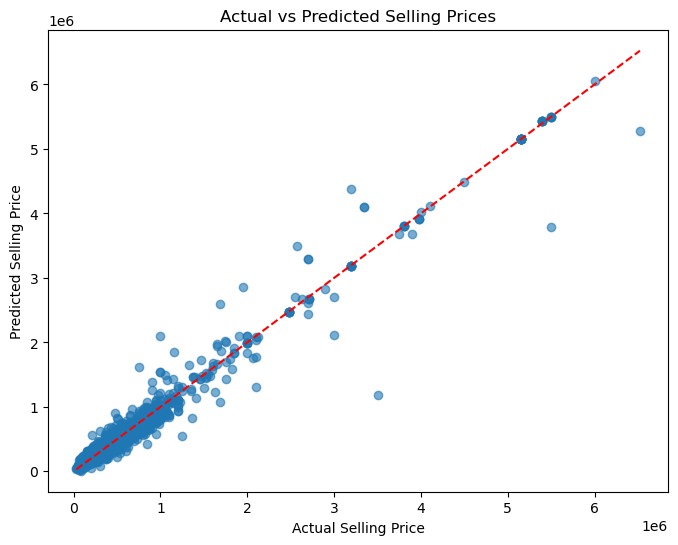

In [181]:
# Get predictions on the test set
y_pred = gs.best_estimator_.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

# Visualize Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("Actual vs Predicted Selling Prices")
plt.show()


In [185]:
print(gs.best_estimator_.named_steps.keys())

dict_keys(['regressor'])


In [191]:
best_model = gs.best_estimator_  # Get the best model from GridSearchCV

# Check if the model has 'feature_importances_' (only applicable for certain models like Random Forest or Gradient Boosting)
if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
    feature_importances = best_model.named_steps['regressor'].feature_importances_
    feature_names = ['feature1', 'feature2']  # Replace with your actual feature names

    # Create a DataFrame for feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print(importance_df)
else:
    print("The best model does not support feature importances.")


ValueError: All arrays must be of the same length

In [193]:
X_train.columns

Index(['km_driven', 'mileage', 'engine', 'max_power', 'seats', 'car_age',
       'fuel_Diesel', 'fuel_LPG', 'fuel_Petrol', 'seller_type_Individual',
       'seller_type_Trustmark Dealer', 'transmission_Manual',
       'owner_Fourth & Above Owner', 'owner_Second Owner',
       'owner_Test Drive Car', 'owner_Third Owner'],
      dtype='object')